### Examine spatial fetalization for the Kanemaru dataset

- Does processing with specifics to the Kanemaru dataset

In [1]:
import scanpy as sc
import pandas as pd
import pandas as pd 
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
from libpysal.weights import KNN
from esda.moran import Moran

In [3]:
# directory with fetalization genes
fetalization_gene_dir = "../../../aggregated_analysis/pseudobulked_analysis/pydeseq2/fetalization_genes/"
# all disease DEGs 
disease_genes_dir = "../../../aggregated_analysis/pseudobulked_analysis/pydeseq2/pydeseq2_results/"

In [4]:
adata_fetalization_dir = "adata_with_weighted_fetalization_scores/"
os.makedirs(adata_fetalization_dir, exist_ok=True)
plots_dir = adata_fetalization_dir + "plots/"
os.makedirs(plots_dir, exist_ok=True)

In [5]:
def preprocess_spatial(adata):
    '''Preprocess the Kanemaru spatial adata files'''
    
    # store the raw counts
    adata.layers['counts'] = adata.X

    # log normalize the counts
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

    # spatial coordinates are here: adata.obsm['X_spatial']
    return adata

In [6]:
def identify_significant_up_DEGs(deseq2_results_path):
    '''Extract the significant DEGs'''
    deseq2_results_df = pd.read_csv(deseq2_results_path, index_col = 0)
    sig_genes =  deseq2_results_df.loc[(deseq2_results_df['significant'] == True) & (deseq2_results_df['log2FoldChange'] > 0), ]
    sig_genes_list = list(sig_genes.index)
    return(sig_genes_list)

In [7]:
def obtain_fetalization_score(adata, fetalization_gene_list, score_name):
    '''Calculate the gene score for a list of fetalization genes'''
    sc.tl.score_genes(adata, fetalization_gene_list, score_name=score_name)
    return(adata)

In [8]:
def visualize_fetalization(adata, score_name):
    '''Visualize the fetalization score (score_name) for Kanemaru adata'''

    fig, ax = plt.subplots()
    
    sc.pl.spatial(
        adata,
        color=[score_name],  
        img_key="hires",  
        size=1.8,
         cmap = 'magma',
        alpha_img=0.6,
        title="Expression of " + score_name, 
        vmax=-1, vmin = 1,
        ax = ax, show = False
    )

    return fig

In [9]:
def compute_cell_type_props(adata):
    '''Compute the cell type proportion by summing across subclusters''' 

    # get cell type proportions stored in adata.obsm['prop']
    adata_subset.obsm['prop'] = adata_subset.obsm['prop'].fillna(0)
    
    cell_type_dict = {
        'Adipocyte': ['Adip1', 'Adip2', 'Adip3'],
        'Cardiomyocyte': ['vCM1', 'vCM2', 'vCM3_stressed', 'vCM4', 'vCM5'],
        'Endocardial': ['EC7_endocardial'],
        'Endothelial': ['EC1_cap', 'EC2_cap', 'EC3_cap', 'EC4_immune', 'EC5_art', 'EC6_ven'],
        'Epicardial': ['Meso'],
        'Fibroblast': ['FB1', 'FB2', 'FB3', 'FB4_activated', 'FB5', 'FB6'],
        'LEC': ['EC8_ln'],
        'Lymphoid': ['NK_CD16hi', 'NK_CD56hi', 'NK_CD56hi', 'T/NK_cycling', 
                     'B_plasma', 'B', 'CD4+T_act', 'CD8+T_trans', 
                     'CD4+T_naive', 'CD8+T_cytox', 'CD8+T_em', 'CD8+T_te', 'CD8+T_trans'],
        'Mast': ['Mast'],
        'Myeloid': ['CD14+Mo', 'CD16+Mo', 'MoMP', 'DC', 'LYVE1+IGF1+MP', 'LYVE1+MP_cycling', 'LYVE1+TIMD4+MP'],
        'Neuronal': ['NC1_glial'],
        'Pericyte': ['PC1_vent', 'PC2_atria', 'PC3_str', 'PC4_CMC-like'],
        'vSMC': ['SMC1_basic', 'SMC2_art']
    }

    # sum the proportions up
    for cell_type, components in cell_type_dict.items():
        adata.obs[cell_type] = adata_subset.obsm['prop'][components].sum(axis=1)

    # get the other category 
    adata.obs['other'] = 1 - (adata.obs[list(cell_type_dict.keys())].sum(axis=1))

    return adata

In [10]:
adata_list_dir = "../processed_data/"

### Load in the adata

In [11]:
adata = sc.read_h5ad("../processed/visium-OCT_LV_lognormalised.h5ad")
adata

AnnData object with n_obs × n_vars = 9626 × 33538
    obs: 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'sangerID', 'region', 'donor', 'donor_type', 'age', 'gender', 'facility', 'modality', 'kit_10x', 'flushed', 'annotation_final', 'Adip1', 'Adip2', 'Adip3', 'B', 'B_plasma', 'CD14+Mo', 'CD16+Mo', 'CD4+T_act', 'CD4+T_naive', 'CD8+T_cytox', 'CD8+T_em', 'CD8+T_te', 'CD8+T_trans', 'DC', 'EC10_CMC-like', 'EC1_cap', 'EC2_cap', 'EC3_cap', 'EC4_immune', 'EC5_art', 'EC6_ven', 'EC7_endocardial', 'EC8_ln', 'FB1', 'FB2', 'FB3', 'FB4_activated', 'FB5', 'FB6', 'ILC', 'LYVE1+IGF1+MP', 'LYVE1+MP_cycling', 'LYVE1+TIMD4+MP', 'MAIT-like', 'Mast', 'Meso', 'MoMP', 'NC1_glial', 'NC2_glial_NGF+', 'NK_CD16hi', 'NK_CD56hi', 'Neut', 'PC1_vent', 'PC2_atria', 'PC3_str', 'SAN_P_cell', 'SMC1_basic', 'SMC2_art', 'T/NK_cycling', 'aCM1', 'aCM2', 'aCM3', 'aCM4', 'AVN_bundle_cell', 'PC4_CMC-like', 'vCM1', 'vCM2', 'vCM3_stressed', 'vCM4', 'vCM5', 'AVN_P_c

In [12]:
def preprocess_spatial(adata):
    '''Preprocess the Kanemaru spatial adata files'''
    
    # store the raw counts
    adata.layers['counts'] = adata.X

    # log normalize the counts
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

    # spatial coordinates are here: adata.obsm['X_spatial']
    return adata

In [13]:
#adata = preprocess_spatial(adata)

In [14]:
#adata_dict = {
#    sample: adata[adata.obs["sangerID"] == sample].copy() 
#    for sample in adata.uns["spatial"].keys()
#}

In [15]:
sample_names = adata.obs["sangerID"].unique()

#### Test for one adata 

In [16]:
sample_name = sample_names[0]
adata_subset = adata[adata.obs['sangerID'] == sample_name].copy()
adata_subset.uns["spatial"] = {sample_name: adata.uns["spatial"][sample_name]}

In [17]:
adata_subset

AnnData object with n_obs × n_vars = 2891 × 33538
    obs: 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'sangerID', 'region', 'donor', 'donor_type', 'age', 'gender', 'facility', 'modality', 'kit_10x', 'flushed', 'annotation_final', 'Adip1', 'Adip2', 'Adip3', 'B', 'B_plasma', 'CD14+Mo', 'CD16+Mo', 'CD4+T_act', 'CD4+T_naive', 'CD8+T_cytox', 'CD8+T_em', 'CD8+T_te', 'CD8+T_trans', 'DC', 'EC10_CMC-like', 'EC1_cap', 'EC2_cap', 'EC3_cap', 'EC4_immune', 'EC5_art', 'EC6_ven', 'EC7_endocardial', 'EC8_ln', 'FB1', 'FB2', 'FB3', 'FB4_activated', 'FB5', 'FB6', 'ILC', 'LYVE1+IGF1+MP', 'LYVE1+MP_cycling', 'LYVE1+TIMD4+MP', 'MAIT-like', 'Mast', 'Meso', 'MoMP', 'NC1_glial', 'NC2_glial_NGF+', 'NK_CD16hi', 'NK_CD56hi', 'Neut', 'PC1_vent', 'PC2_atria', 'PC3_str', 'SAN_P_cell', 'SMC1_basic', 'SMC2_art', 'T/NK_cycling', 'aCM1', 'aCM2', 'aCM3', 'aCM4', 'AVN_bundle_cell', 'PC4_CMC-like', 'vCM1', 'vCM2', 'vCM3_stressed', 'vCM4', 'vCM5', 'AVN_P_c

In [18]:
adata_subset = adata_subset

In [19]:
adata_subset.obs.columns

Index(['array_row', 'array_col', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'sangerID', 'region', 'donor', 'donor_type', 'age', 'gender',
       'facility', 'modality', 'kit_10x', 'flushed', 'annotation_final',
       'Adip1', 'Adip2', 'Adip3', 'B', 'B_plasma', 'CD14+Mo', 'CD16+Mo',
       'CD4+T_act', 'CD4+T_naive', 'CD8+T_cytox', 'CD8+T_em', 'CD8+T_te',
       'CD8+T_trans', 'DC', 'EC10_CMC-like', 'EC1_cap', 'EC2_cap', 'EC3_cap',
       'EC4_immune', 'EC5_art', 'EC6_ven', 'EC7_endocardial', 'EC8_ln', 'FB1',
       'FB2', 'FB3', 'FB4_activated', 'FB5', 'FB6', 'ILC', 'LYVE1+IGF1+MP',
       'LYVE1+MP_cycling', 'LYVE1+TIMD4+MP', 'MAIT-like', 'Mast', 'Meso',
       'MoMP', 'NC1_glial', 'NC2_glial_NGF+', 'NK_CD16hi', 'NK_CD56hi', 'Neut',
       'PC1_vent', 'PC2_atria', 'PC3_str', 'SAN_P_cell', 'SMC1_basic',
       'SMC2_art', 'T/NK_cycling', 'aCM1', 'aCM2', 'aCM3', 'aCM4',
       'AVN_bundle_cell', 'PC4_CMC-like', 'vCM1', 'vCM2', 'v

#### Aggregate the subclustered cell type proportions together

In [20]:
# compute the cell type proportions
adata_subset = compute_cell_type_props(adata_subset)

In [21]:
# confirm that the proportions add to one
adata_subset.obs['total_prop'] = (adata_subset.obs['Adipocyte']  + adata_subset.obs['Cardiomyocyte']  + adata_subset.obs['Endocardial'] +
                                   adata_subset.obs['Epicardial'] +
                           adata_subset.obs['Endothelial'] + adata_subset.obs['Fibroblast'] + adata_subset.obs['LEC'] + 
                          adata_subset.obs['Lymphoid'] + adata_subset.obs['Mast'] + adata_subset.obs['Myeloid'] + adata_subset.obs['Neuronal']  +
                          adata_subset.obs['Pericyte']  + adata_subset.obs['vSMC'] + adata_subset.obs['other'])

adata_subset.obs['total_prop'].head()

spot_id
HCAHeartST8795933_AAACAAGTATCTCCCA-1    1.0
HCAHeartST8795933_AAACACCAATAACTGC-1    1.0
HCAHeartST8795933_AAACAGCTTTCAGAAG-1    1.0
HCAHeartST8795933_AAACAGGGTCTATATT-1    1.0
HCAHeartST8795933_AAACCCGAACGAAATC-1    1.0
Name: total_prop, dtype: float64

In [22]:
cell_types = ["Cardiomyocyte", "Endothelial", "Fibroblast", "Myeloid", "Lymphoid", "Neuronal", "Pericyte", "vSMC"]

CPU times: user 16.8 s, sys: 3.13 s, total: 19.9 s
Wall time: 17.2 s


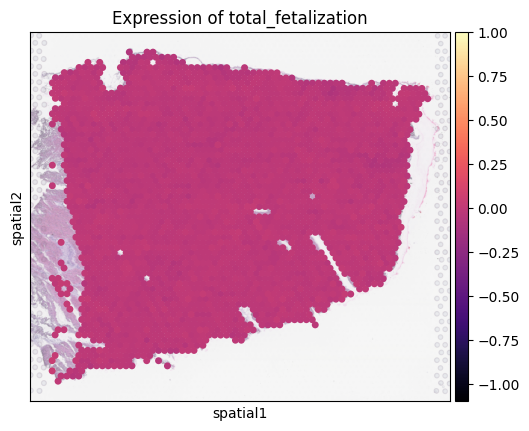

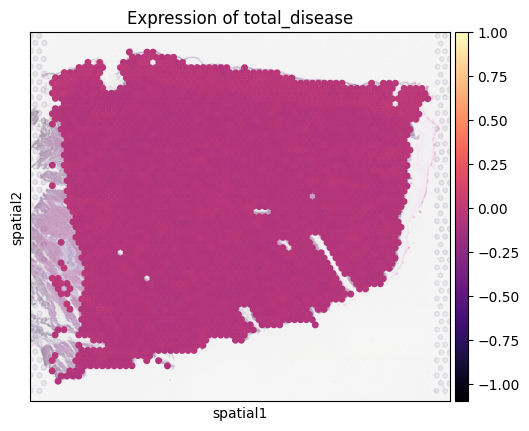

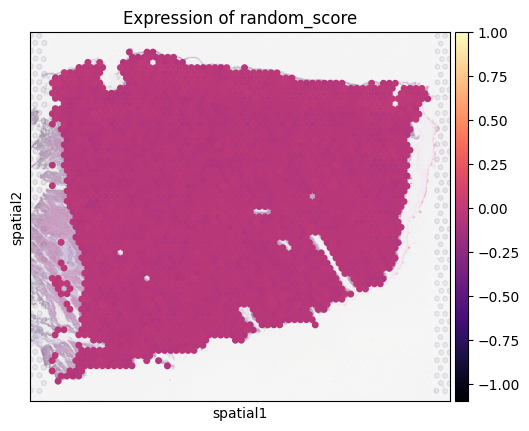

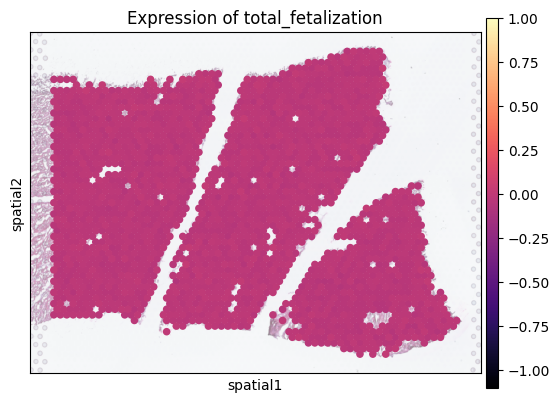

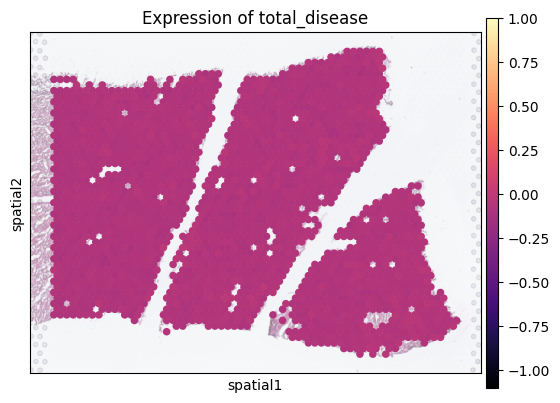

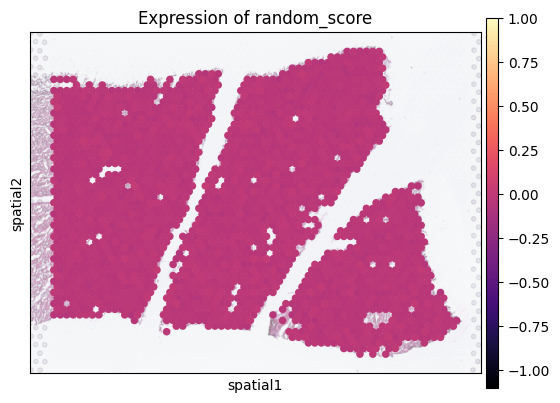

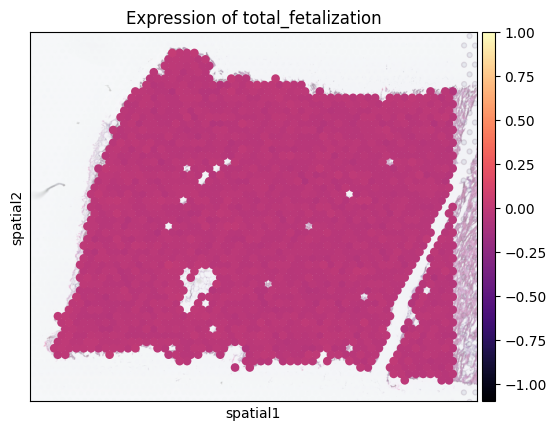

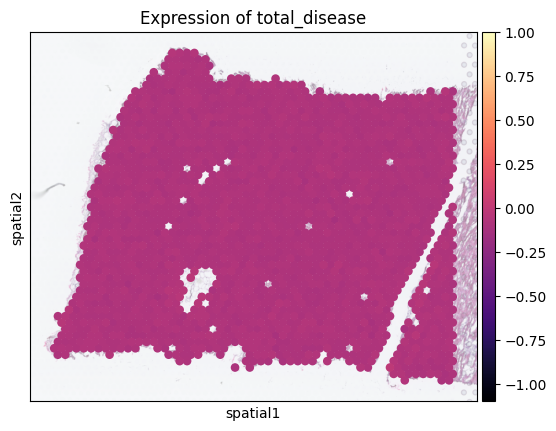

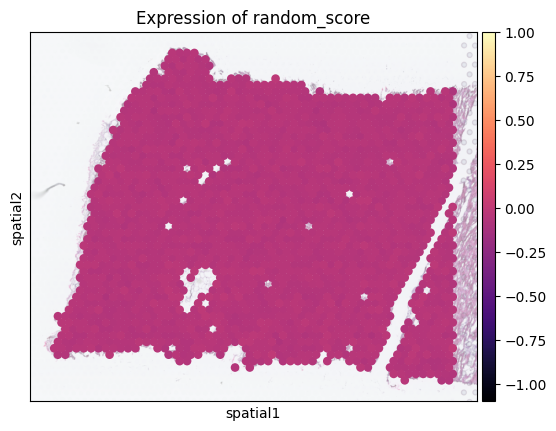

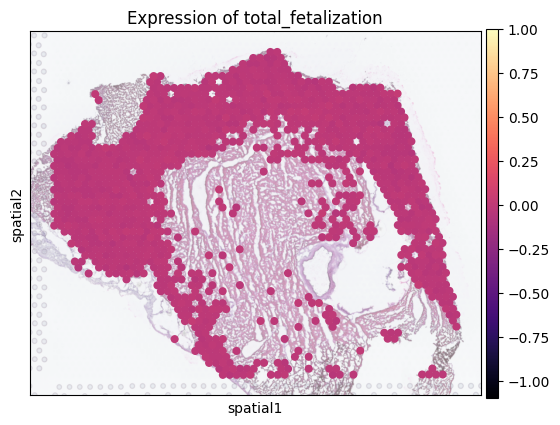

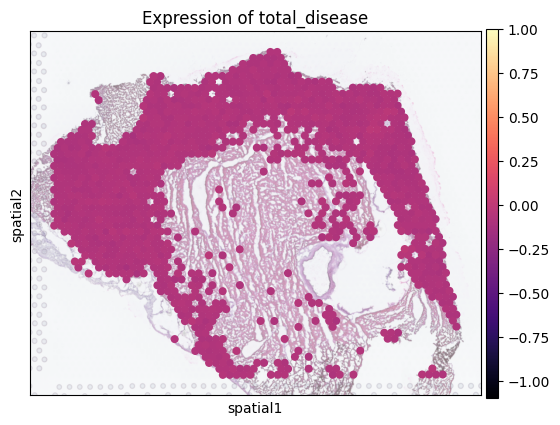

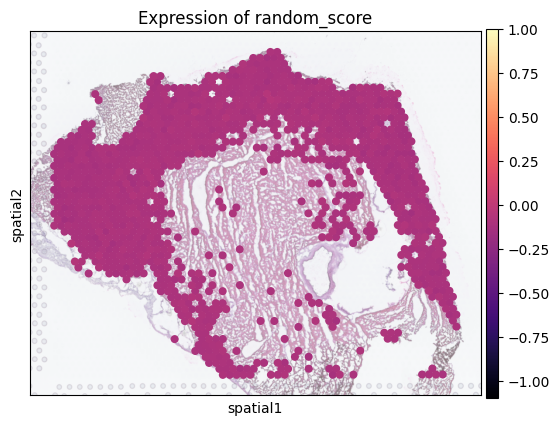

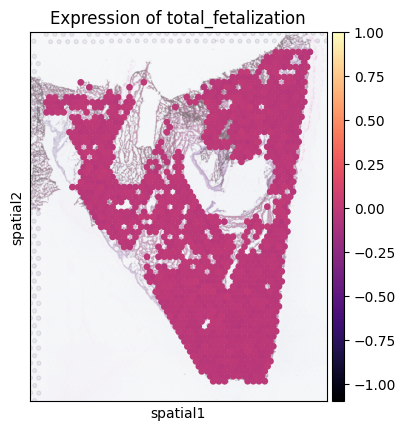

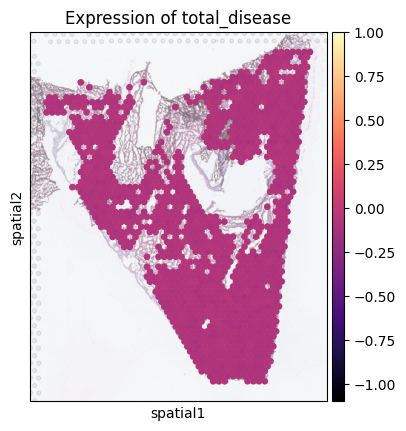

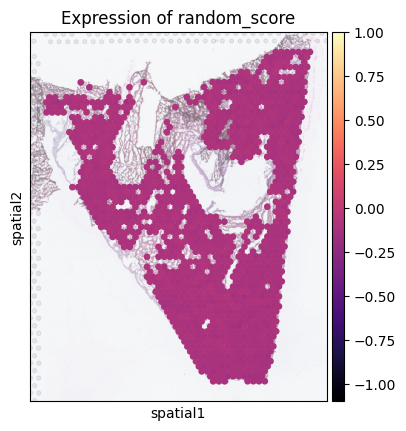

In [23]:
%%time

direction = "up"
total_fetalization_score = "total_fetalization"
total_disease_score = "total_disease"
random_fetalization_score = "random_score"

for sample_name in sample_names:

    # filter adata to just this sample_id
    adata_subset = adata[adata.obs['sangerID'] == sample_name].copy()
    adata_subset.uns["spatial"] = {sample_name: adata_subset.uns["spatial"][sample_name]}

    # compute the cell type proportions
    adata_subset = compute_cell_type_props(adata_subset)
    #adata = preprocess_spatial(adata)

    for cell_type in cell_types:

        # get fetalization score
        fetalization_score_name = cell_type + " fetalization: " + direction
        fetalization_gene_path = fetalization_gene_dir + cell_type + "_" + direction + "_fetalization_genes.csv" 
        df = pd.read_csv(fetalization_gene_path)
        fetalization_gene_list = list(df['0'])
        adata_subset = obtain_fetalization_score(adata_subset, 
                                          fetalization_gene_list = fetalization_gene_list, 
                                          score_name = fetalization_score_name)

        # get disease score
        disease_gene_path = disease_genes_dir + cell_type + "_disease-binary_Y_vs_N_results.csv"
        disease_gene_list = identify_significant_up_DEGs(disease_gene_path)
        disease_score_name = cell_type + " disease: " + direction
        adata_subset = obtain_fetalization_score(adata_subset, 
                                          fetalization_gene_list = disease_gene_list, 
                                          score_name = disease_score_name)
        
        # get a random gene set of equal size to the fetalization gene set
        random_features = np.random.choice(adata_subset.var_names, size=len(fetalization_gene_list), replace=False)
        random_score_name = cell_type + " random: " + direction
        adata_subset = obtain_fetalization_score(adata_subset, fetalization_gene_list=random_features, score_name = random_score_name)

    for cell_type in cell_types:
        # get sum of the products of each cell type and its corresponding fetalization value
        total_fetalization = sum(adata_subset.obs[ct] * adata_subset.obs[f"{ct} fetalization: {direction}"] for ct in cell_types)
        adata_subset.obs[total_fetalization_score] = total_fetalization

        total_disease = sum(adata_subset.obs[ct] * adata_subset.obs[f"{ct} disease: {direction}"] for ct in cell_types)
        adata_subset.obs[total_disease_score] = total_disease
    
        random_fetalization = sum(adata_subset.obs[ct] * adata_subset.obs[f"{ct} random: {direction}"] for ct in cell_types)
        adata_subset.obs[random_fetalization_score] = random_fetalization

    # produce the plots
    spatial_fetalization_plot = visualize_fetalization(adata_subset, score_name = total_fetalization_score)
    spatial_fetalization_plot.savefig(plots_dir + sample_name + "_actual_fetalization_spatial_plot.pdf")

    spatial_disease_plot = visualize_fetalization(adata_subset, score_name = total_disease_score)
    spatial_disease_plot.savefig(plots_dir + sample_name + "_actual_disease_spatial_plot.pdf") 

    random_spatial_plot = visualize_fetalization(adata_subset, score_name = random_fetalization_score)
    random_spatial_plot.savefig(plots_dir + sample_name + "_RANDOM_fetalization_spatial_plot.pdf") 

    # save the adata with the fetalization scores
    adata_subset.write(adata_fetalization_dir + sample_name + ".h5ad")

### Calculate proportion of fetalization spots and Moran's I

In [24]:
def calculate_fetalization_prop_and_Moran(adata, fetalization_score_name, fetalization_threshold = 0):
    '''Computes Moran's I for gene list and also a null set of random list of genes of the same size. 
    Also computes the percentage of spots with fetalization score > threshold'''
    
    coords = adata.obsm["spatial"]
    w = KNN.from_array(coords, k=6)
    
    # calculate proportional of fetalization scores 
    proportional_fetalization_spots = sum(adata.obs[fetalization_score_name] > fetalization_threshold) / adata.obs.shape[0]

    # row-standardization
    w.transform = "R" 
    fetal_score = adata.obs[fetalization_score_name].values
    moran_fetal = Moran(fetal_score, w)

    fetal_I = moran_fetal.I
    fetal_p = moran_fetal.p_norm

    return(proportional_fetalization_spots, fetal_I, fetal_p)

In [25]:
results_list = []

for sample_name in sample_names:

    print(sample_name, flush=True)
    adata = sc.read_h5ad(adata_fetalization_dir + sample_name + ".h5ad")
    prop_fetalization, fetal_Moran, fetal_Moran_p = calculate_fetalization_prop_and_Moran(adata, 
                                                                                          fetalization_score_name = total_fetalization_score)

    # append results to list
    results_list.append({
                "sample": sample_name,
                "prop_fetalization_spots": prop_fetalization,
                "fetal_Moran": fetal_Moran,
                "fetal_Moran_p": fetal_Moran_p,
            })

# convert list to df
results_df = pd.DataFrame(results_list)

HCAHeartST8795933
HCAHeartST9383352
HCAHeartST9383354
HCAHeartST9383356
HCAHeartST9383358


### Visualize results

In [26]:
results_df["region"] = "control"

In [27]:
results_df.head()

,sample,prop_fetalization_spots,fetal_Moran,fetal_Moran_p,region
0,HCAHeartST8795933,0.104116,0.289446,1.721114e-163,control
1,HCAHeartST9383352,0.034513,0.055944,2.370938e-06,control
2,HCAHeartST9383354,0.010613,0.098544,2.664816e-15,control
3,HCAHeartST9383356,0.071184,0.130056,1.566527e-15,control
4,HCAHeartST9383358,0.042071,0.134936,1.883487e-17,control


Text(0, 0.5, 'Moran I for fetalization genes')

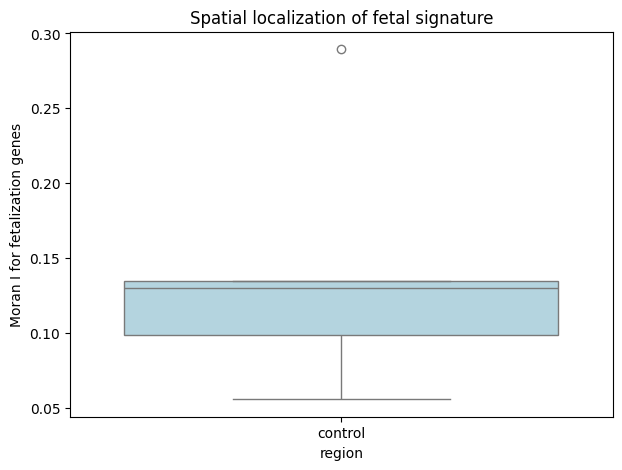

In [28]:
desired_order = ["control"]
plt.figure(figsize = (7, 5))
sns.boxplot(data = results_df, x = 'region', y = 'fetal_Moran', color = 'lightblue', order=desired_order)
plt.title("Spatial localization of fetal signature")
plt.xlabel("region")
plt.ylabel("Moran I for fetalization genes")

Text(0, 0.5, 'Proportion')

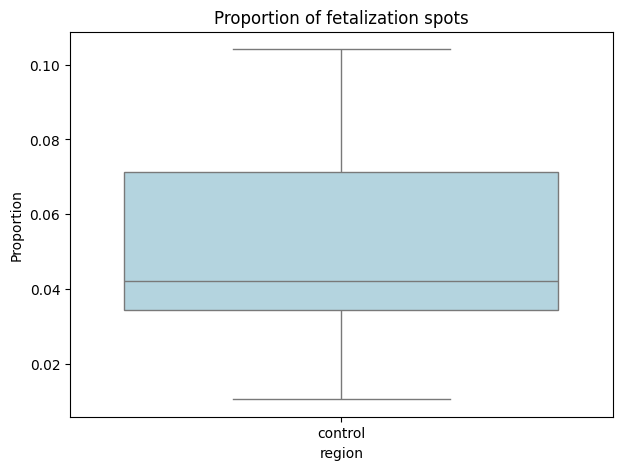

In [29]:
desired_order = ["control"]
plt.figure(figsize = (7, 5))
sns.boxplot(data = results_df, x = 'region', y = 'prop_fetalization_spots', color = 'lightblue', order=desired_order)
plt.title("Proportion of fetalization spots")
plt.xlabel("region")
plt.ylabel("Proportion")

In [30]:
results_df.to_csv("Kanemaru_Moran_I_results.csv")